### Task 2
Implement a circuit that returns $|01>$ and $|10>$ with equal probability.
Requirements :
-	The circuit should consist only of CNOTs, RXs and RYs. 
-	Start from all parameters in parametric gates being equal to 0 or randomly chosen. 
-	You should find the right set of parameters using gradient descent (you can use more advanced optimization methods if you like). 
-	Simulations must be done with sampling (i.e. a limited number of measurements per iteration) and noise. 

Compare the results for different numbers of measurements: 1, 10, 100, 1000. 

Bonus question:
How to make sure you produce state $|01> + |10>$ and not $|01> - |10>$?

(Actually for more careful readers, the “correct” version of this question is posted below:
How to make sure you produce state  $|01> + |10>$  and not any other combination of $|01> + e^{i\phi}|10>$|01> + |10⟩ (for example $|01> - |10>$)?)


## Solution

The solution const of the following steps:

1) Circuit implementation in qiskit.

2) Adding noise to the circuit.

3) Using error correction to filter the noise of the circuit.

4) The cost function.

5) The gradient descent optimization implementation.

6) Conclusion

7) Bonus Question

### 1) Circuit implementation in qiskit:

The first step is to create a quantum circuit with parametric entries. The target state is the following Bell state 

$$| \Psi^+> = \frac{1}{\sqrt{2}}(|01> + |10>)$$

Therefore, we need a rotation about y-axis in the first qubit and a rotation about x-axis in the second qubit followed by a CNOT gate to get such state. In this approach, I will work with qiskit a python quantum library from IBM to simulate the quantum circuit.

In [29]:
# Importing needed libraries
import qiskit as qk
from qiskit.circuit import Parameter
import numpy as np

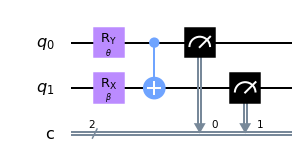

In [30]:
backend = qk.Aer.get_backend("qasm_simulator") # Backend that simulates the outcomes of a experiment with shots
circuit = qk.QuantumCircuit(2,2) # Create a quantum circuit with 2 qubits and 2 measurement lines
theta, beta = Parameter(r"$\theta$"),Parameter(r"$\beta$") #Parametric angles
circuit.ry(theta,0) #Rotation around x with parametric theta0
circuit.rx(beta,1) #Rotation around x with parametric theta1
circuit.cx(0,1)      #CNOT gate to create the entanglement
circuit.measure((0,1),(0,1)) # Measure the outcome q0: line 0 and q1: line 1
circuit.draw("mpl") #Showing the circuit

### 2) Noise Model

The noise in this quantum circuit will be given by a random flip in the measurement step with a $10\%$ of probability of occurence. To do this, I will use the noise model provided by qiskit with a pauli error function.

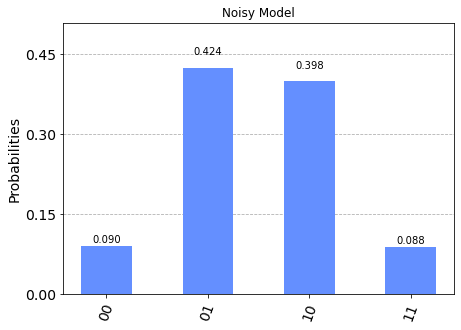

In [268]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
from qiskit.visualization import plot_histogram

noise_model = NoiseModel() # Noise model from qiskit
noise = 0.1 # 10% of random fliping own to the measurement process 
error_meas = pauli_error([("X", noise), ("I", 1 - noise)])
noise_model.add_all_qubit_quantum_error(error_meas,"measure") #Add the error to the measurement process


noise_circuit = circuit.assign_parameters({theta:np.pi/2,beta:np.pi}) 
job = qk.execute(noise_circuit, backend = backend, noise_model = noise_model) # Execute the noisy model in 
                                                                                # with the qasm_simulator
noise_result = job.result()
noise_counts = noise_result.get_counts()
plot_histogram(noise_counts,title = "Noisy Model")

### 3) Using error correction to filter the noise of the circuit

I use a error mitigation technique to clean the noise when I calculate the fidelity. Here, it is necessary to calculate the M matrix which gives me a noise state vector 

$$|\psi_{noise}> = M |\psi_{ideal}>$$

Then, founding $M^{-1}$, it is possible to calculate the ideal state vector

$$|\psi_{ideal}> = M^{-1} |\psi_{noise}>$$. 

To calculate the matrix M, we explore the whole Hilbert space to find the outcome of each eigenstate.
For example, if I prepare the first states $|00>$, $|01>$, $|10>$, and $|1>$ and get the output of 1000 shots:

$$00 = {00:9823, 01:15, 10: 38, 11: 24}$$
$$01 = {00:11, 01:9920, 10: 74, 11: 15}$$
$$10 = {00:14, 01:25, 10: 9910, 11: 61}$$
$$11 = {00:9, 01:95, 10: 6, 11: 9890}$$

The matrix M is:

$$M = \left(\begin{matrix}0.9823&0.0011&0.0014&0.0009\\
                          0.0015&0.9920&0.0025&0.0095\\
                          0.0038&0.0074&0.9910&0.0006\\
                          0.0024&0.0015&0.0061&0.9890\end{matrix}\right)$$

In [269]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal,CompleteMeasFitter)

qr = qk.QuantumRegister(2) # Create a quantum register and add the different set of circuits to explore the Hilbert space
meas_calibs, state_labels = complete_meas_cal(qr = qr, circlabel = "mcal") #Preparing the set of circuits 
jobs = qk.execute(meas_calibs,backend = backend, shots = 1000, noise_model = noise_model)# Executing the set of circuit with the noisy model
meas_fitter = CompleteMeasFitter(jobs.result(),state_labels, circlabel = 'mcal') # get the matrix M
print("M = ", meas_fitter.cal_matrix)

M =  [[0.819 0.108 0.089 0.008]
 [0.086 0.784 0.009 0.095]
 [0.089 0.014 0.802 0.087]
 [0.006 0.094 0.1   0.81 ]]


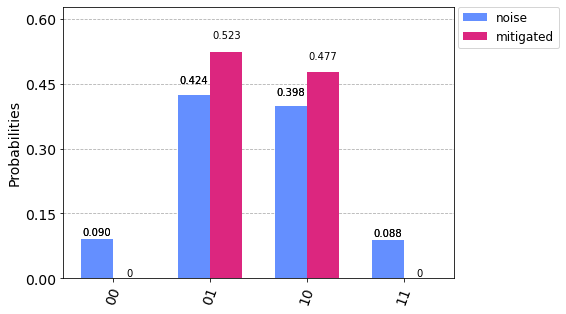

In [270]:
# Now, we can create a circuit which filters the measurement error from que circuit
mitigated_results = meas_fitter.filter.apply(noise_result) # Applying the filter
mitigated_counts = mitigated_results.get_counts()
plot_histogram([noise_counts,mitigated_counts], legend = ["noise","mitigated"])

### 4) The cost function

The second step is to define the cost function. In this case, I am going to work with the Fidelity which indicates how far from a target state my state is. The case of $F = 1$ indicates that my state is the same that the target state. I will minimize the following function,

$$cost(\theta,\beta) = (1 - F(\theta, \beta))^2$$

where, the Findelity $F = <\psi|\rho_T|\psi>$, the outcome of the above circuit is $|\psi>$, the target density matrix is $\rho = |\psi_{target}><\psi_{target}|$, and the target state vector $|\psi_{target}> = | \Psi^+> = \frac{1}{\sqrt{2}}(|01> + |10>)$.

Ideally, after applying the $ry(\theta)$ in the first qubit, $rx(\beta)$ in the second qubit, and the CNOT gate with control first qubit and target second qubit, the circuit outcome is: 

$$|\psi> = \left(\begin{matrix}
                cos(\theta/2)\ cos(\beta/2)\\
                -i cos(\theta/2)\ sin(\beta/2)\\
                -i sin(\theta/2)\ sin(\beta/2)\\
                sin(\theta/2)\ cos(\beta/2)\end{matrix}\right)$$
                
The Fidelity: 
$$F = \frac{1}{2}sin^2(\beta/2)(1 + sin(\theta))$$
                
while the cost function is:
                
$$cost(\theta,\beta)= \left(1 \ - \ \frac{1}{2}sin^2(\beta/2)\ (1 + sin(\theta))\right)^2$$


In [248]:
def state_vector(angles, circuit, psi, shots, backend, noise_model, meas_fitter):
    """State Vector without global phase
    Based on the outcome of the experiment this function determines the state vector
    
    Args:
        Angles (list[floats]): parametric angles that rotates the state vector around x for qubit 0 and qubit 1
                                respectively
        Circuit (qiskit Circuit): parametric circuit with a rx gates in each qubit
        psi     (dictionary): Dictionary with keys 00 01 10 11 
        shots   (int): Number of experiments used to get the probability 
        noise_model (qiskit aer noise class): Noise of the system
        meas_fitter (qiskit Matrix M): eigenvalues set solution using the function CompleteMeasFitter()
    Returns:
        State vector after measurement 
    """
    c = circuit.assign_parameters({theta: angles[0,0],beta: angles[1,0]})
    job = qk.execute(c, backend = backend, shots = shots, noise_model = noise_model)
    noise_result = job.result()
    filter_result = meas_fitter.filter.apply(noise_result)
    result = filter_result.get_counts()
    for i in result:
        psi[i] = result[i]
    psi = np.sqrt(np.array([[psi["00"],psi["01"],psi["10"],psi["11"]]]).T/shots)
    return psi

def cost(psi, pT):
    """Cost function to be minimized.

    Args:
        psi (array[float]): Output state vector from the qiskit circuit
        pT  (array[float,float]): Target density matrix(Square matrix) 
    Returns:
        float: loss value to be minimized
    """
    f = psi.T.dot(pT.dot(psi))[0,0] # Fidelity 
    loss = (1 - f) ** 2
    return loss

### 5) Gradient Descent Optimization:
The next step is to create a function to determine the evolution of the parameters $\theta$ and $\beta$ based on the gradient descent formula:

$$\vec{x_{n+1}} = \vec{x_n} - \gamma_n \nabla f(\vec{x_n})$$

$$\gamma_n = \frac{\left|(\vec{x_{n}} - \vec{x_{n - 1}})^T \left[\nabla f(\vec{x_{n}}) - \nabla f(\vec{x_{n-1}})\right]\right|}{||\nabla f(\vec{x_{n}}) - \nabla f(\vec{x_{n-1}})||^2}$$

where $\vec{x_n} = \left(\begin{matrix} \theta_{n} \\ \beta_{n} \end{matrix}\right)$, $f = cost(\theta,\beta)$, and $\gamma_n$ is the learning rate.

$$\left(\begin{matrix} \theta_{n+1} \\ \beta_{n+1} \end{matrix}\right) = \left(\begin{matrix} \theta_{n} \\ \beta_{n} \end{matrix}\right) - \gamma_n \left(\begin{matrix} \frac{\partial}{\partial \theta} cost(\theta,\beta)\\ \frac{\partial}{\partial \beta} cost(\theta,\beta) \end{matrix}\right)$$


$$\left(\begin{matrix} \frac{\partial}{\partial \theta} cost(\theta,\beta)\\ \frac{\partial}{\partial \beta} cost(\theta,\beta) \end{matrix}\right) = -sin^2(\beta/2)(1 - F)\left(\begin{matrix}cos(\theta)\\ (1 + sin(\theta))/tan(\beta/2))\end{matrix}\right)$$

In [249]:
def Fidelity(angles):
    """
    Parametric circuit fidelity

    Parameters
    ----------
    angles : array[2,1]
        Angles of the two parameters in the qiskit circuit [theta, beta].

    Returns
    -------
    float
        Fidelity given by the equations of the circuit after applying a ry(theta) gate in the first qubit and a rx(beta)
        in the second qubit, followed by a CNOT gate.

    """
    return 0.5 * np.sin(angles[1,0]/2)**2 *(1 + np.sin(angles[0,0]))

    
def gradientf(angles):
    """
    Cost function gradient based on the parametric circuit preseted above.

    Parameters
    ----------
    angles : Array([2,1])
        Parametric angles theta and beta .

    Returns
    -------
    Array[2,1]
        Gradient of the cost function.

    """
    theta = angles[0,0]
    beta = angles[1,0]
    f = Fidelity(angles)
    return -np.sin(beta/2)**2 * (1 - f) * np.array([[np.cos(theta)],[(1 + np.sin(theta))/np.tan(beta/2)]])

In [279]:
psi_dic = {"00":0,"01":0,"10":0,"11":0} # initialize a dictionary with the possible outcomes
psiT = np.sqrt(np.array([[0,0.5,0.5,0]]).T) # Target state vector 
pT = psiT.dot(psiT.T) # Target density state
set_shots = [1, 10, 100, 1000] # Different number of shots for the experiment
shots_results = [] # Saving the results of the different number of shots in a list
for shots in set_shots:
    angles = 2*np.pi*np.random.uniform(size = (2,1)) # Random initial angles theta and beta between 0 and pi
    angles += 1e-12 # If the initial condition is zero, it should take the algorithm out of the singular point
    gamma = 0.01 # Initial learning rate
    args = [circuit, psi_dic, shots, backend, noise_model, meas_fitter]
    results = {"theta":[],"beta":[],"cost":[]}
    print();print(20*"+" + 20*" " + str(shots) + 10*" " + 20*"+");print()
    for i in range(100):
        psi = state_vector(angles, *args) #State vector (without global phase) calculated with the circuit outcomes
        costT = cost(psi,pT) #cost function calculated with the state vector and the ideal output
        results["theta"].append(angles[0,0])
        results["beta"].append(angles[1,0])
        results["cost"].append(costT)
        angles_b = 1*angles
        angles -= gamma*gradientf(angles) #gradient descent step
        delta_gf = gradientf(angles) - gradientf(angles_b) 
        gamma =  abs(((angles - angles_b).T.dot(delta_gf))/(delta_gf.T.dot(delta_gf)))[0,0] #Actualization of gamma
        print("cost: {}, angle1: {:6f}, angle2: {:4f}".format(costT, angles[0,0], angles[1,0]))
        if costT < 1e-10 or (np.isnan(angles[0,0]) or np.isnan(angles[1,0])):
            break
            
    shots_results.append(results)
    


++++++++++++++++++++                    1          ++++++++++++++++++++

cost: 1.0, angle1: 3.673337, angle2: 0.748644
cost: 1.0, angle1: 3.387765, angle2: 1.164402
cost: 1.0, angle1: 2.768732, angle2: 1.897682
cost: 0.2499999999999999, angle1: -0.590953, angle2: 5.425899
cost: 0.9999999999999998, angle1: 0.366529, angle2: 4.308534
cost: 0.9999999999999998, angle1: 2.241198, angle2: 2.507876
cost: 0.9999999999999998, angle1: 1.786842, angle2: 2.935572
cost: 0.24999999254941935, angle1: 1.766498, angle2: 2.954965
cost: 0.24999999254941957, angle1: 1.706422, angle2: 3.012239
cost: 0.2499999973658219, angle1: 1.675905, angle2: 3.041341
cost: 0.24999999736582212, angle1: 1.649110, angle2: 3.066895
cost: 0.9999999999999996, angle1: 1.630114, angle2: 3.085013
cost: 0.2499999882195977, angle1: 1.615475, angle2: 3.098976
cost: 1.0000000000000009, angle1: 1.604534, angle2: 3.109412
cost: 1.0, angle1: 1.596254, angle2: 3.117310
cost: 0.24999998946328805, angle1: 1.590013, angle2: 3.123262
cost:

<ipython-input-279-ce6e1beccf34>:22: RuntimeWarning: invalid value encountered in true_divide
  gamma =  abs(((angles - angles_b).T.dot(delta_gf))/(delta_gf.T.dot(delta_gf)))[0,0] #Actualization of gamma


cost: 0.001303892319650182, angle1: 1.734882, angle2: 3.206256
cost: 0.006534131563059315, angle1: 1.692934, angle2: 3.189756
cost: 0.0054131747757643804, angle1: 1.663289, angle2: 3.178078
cost: 0.0005711518948424024, angle1: 1.640445, angle2: 3.169073
cost: 0.001303892242971189, angle1: 1.623386, angle2: 3.162344
cost: 2.3227132386193648e-05, angle1: 1.610475, angle2: 3.157251
cost: 0.013926146895532574, angle1: 1.600748, angle2: 3.153413
cost: 0.012381897313873342, angle1: 1.593404, angle2: 3.150514
cost: 0.04540234750649763, angle1: 1.587862, angle2: 3.148327
cost: 0.012018247283281595, angle1: 1.583678, angle2: 3.146676
cost: 1.1917620589478264e-05, angle1: 1.580520, angle2: 3.145430
cost: 0.001713807301312648, angle1: 1.578137, angle2: 3.144490
cost: 0.04576588713078253, angle1: 1.576337, angle2: 3.143779
cost: 5.060875460454752e-05, angle1: 1.574979, angle2: 3.143243
cost: 0.012381897808107481, angle1: 1.573954, angle2: 3.142839
cost: 0.01818631986589544, angle1: 1.573180, angle

In [280]:
import matplotlib.pyplot as plt
%matplotlib inline

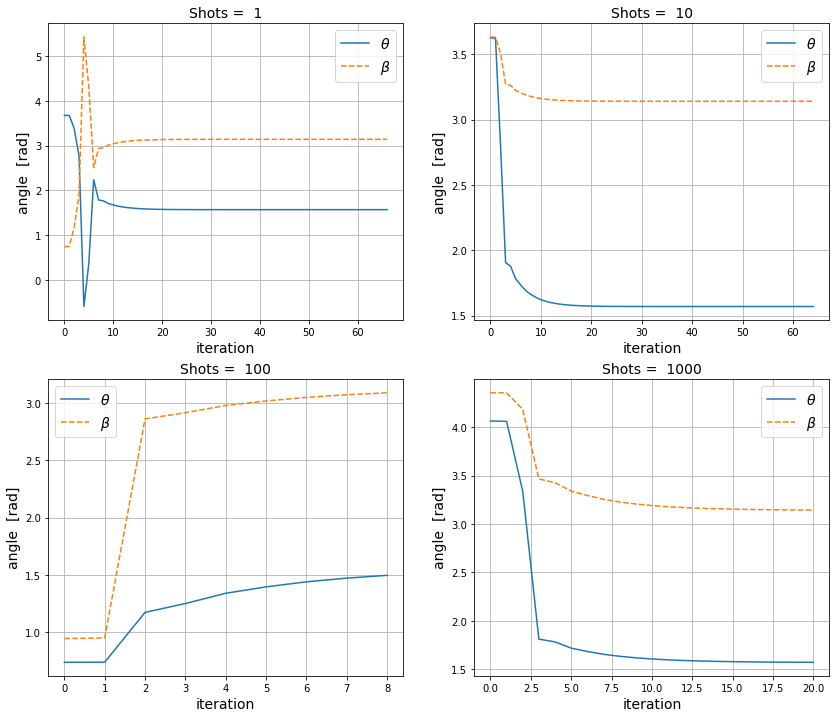

In [281]:
fig, ax = plt.subplots(2,2, figsize = (14,12))
for i in range(len(set_shots)):
    axis = ax[i//2,i%2] 
    axis.plot(shots_results[i]["theta"],label = r'$\theta$')
    axis.plot(shots_results[i]["beta"],"--",label = r"$\beta$")
    axis.legend(fontsize = 14)
    axis.grid()
    axis.set_xlabel("iteration", fontsize = 14)
    axis.set_ylabel("angle  [rad]", fontsize = 14)
    axis.set_title("Shots =  {}".format(set_shots[i]),fontsize = 14)

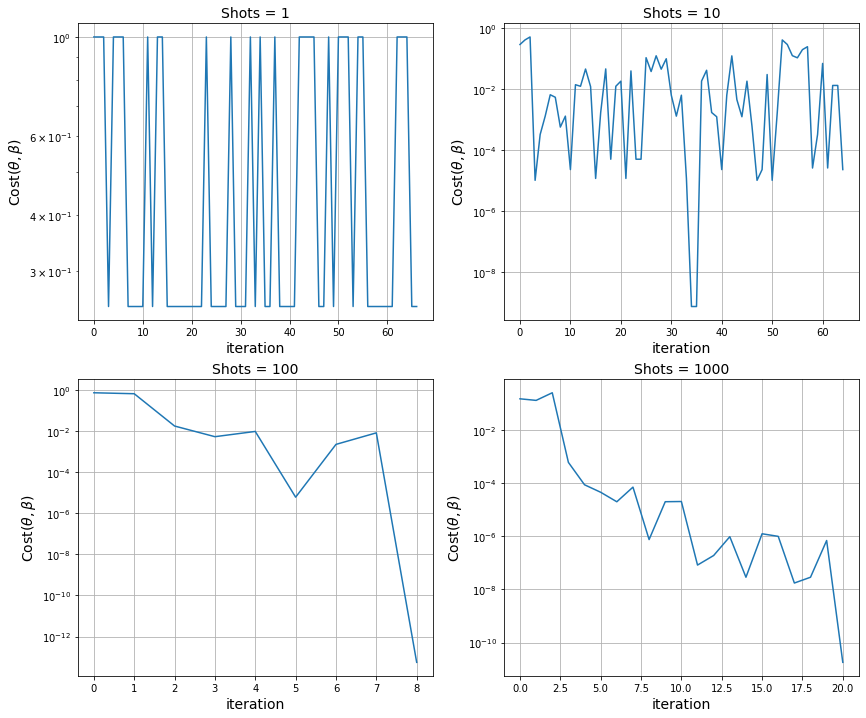

In [282]:
fig2, ax2 = plt.subplots(2,2, figsize = (14,12))
for i in range(len(set_shots)):
    axis = ax2[i//2,i%2]
    axis.plot(shots_results[i]["cost"])
    axis.set_yscale('log')
    axis.grid()
    axis.set_ylabel(r"Cost$(\theta,\beta)$", fontsize = 14)
    axis.set_xlabel("iteration",fontsize = 14)
    axis.set_title("Shots = {}".format(set_shots[i]), fontsize = 14)

### 6 ) Conclusion

In this example, I implemented a method to obtain the angles $\alpha$ and $\beta$ of a parametric circuit that gives the state vector $| \Psi^+> = \frac{1}{\sqrt{2}}(|01\right> + |10>)$. Because the direction of the gradient is based on the theoretical output, the angles always tends to its minimum value. Here, my first approach consisted on take the gradient from the output of the circuit, but this result lose easily when a small number of shots were taken.

For that reason, I opted to use the theoretical approach of the gradient which gives me the results presented above. The circuit includes measurement noise represented by a $10\%$ chance of getting a state flip and a filter to eliminate such noise.



### 7) Bonus Question

Based on the circuit architecture, the first qubit can only rotate about the y-axis, this limits the two possible outcomes after the optimization to be:

$$| \Psi^+> = \frac{1}{\sqrt{2}}(|01> + |10>)$$

$$| \Psi^-> = \frac{1}{\sqrt{2}}(|01> - |10>)$$


However, as I based the gradient on the theoretical solution of the circuit. The fidelity for the state $| \Psi^+> = \frac{1}{\sqrt{2}}(|01> + |10>)$ is

$$F = \frac{1}{2}sin^2(\beta/2)(1 + sin(\theta))$$

Which only give me solutions $\theta = \pi/2 + 2n\pi$.

The Fidelity for the second case $| \Psi^-> = \frac{1}{\sqrt{2}}(|01> - |10>)$ changes as 

$$F = \frac{1}{2}sin^2(\beta/2)(1 - sin(\theta))$$

Which only give me solutions $\theta = 3\pi/2 + 2n\pi$.


Therefore, this implementation ensures a state $$| \Psi^+> = \frac{1}{\sqrt{2}}(|01> + |10>)$$.


